In [1]:
import numpy as np  
import pandas as pd  
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
import os
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from zipfile import ZipFile
from xgboost import XGBRegressor
import seaborn as sns
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pickle
color = sns.color_palette()

%matplotlib inline
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path=os.path.join(dirname, filename)
        if 'train' in path:
            train=path
        elif 'test' in path:
            test=path
        elif 'macro' in path:
            macro=path

In [2]:
def get_zip(path = macro, condition='macro'):
    zip_file = ZipFile(path)
    for text_file in zip_file.infolist():
        if condition in text_file.filename:
            return pd.read_csv(zip_file.open(text_file.filename))
    
df, test_df, macro_df = get_zip(train, condition='train'), get_zip(test, condition='test'), get_zip()
#train_df = pd.merge(df, macro_df, how="left", on="timestamp")
#test_df = pd.merge(test_df, macro_df, how="left", on="timestamp")

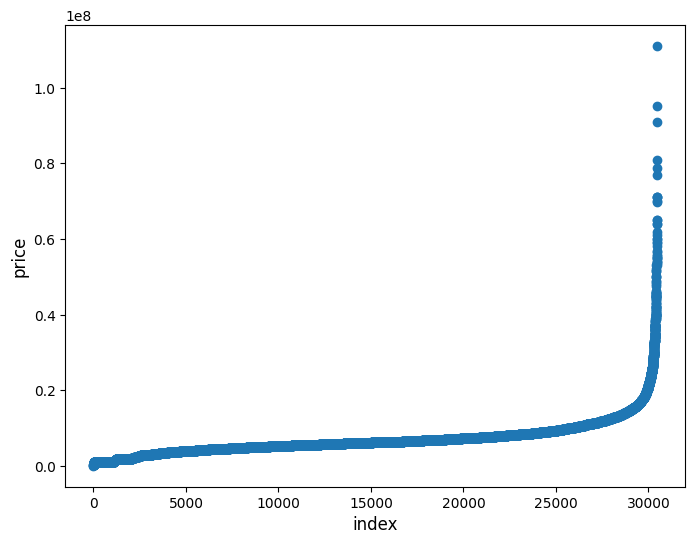

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

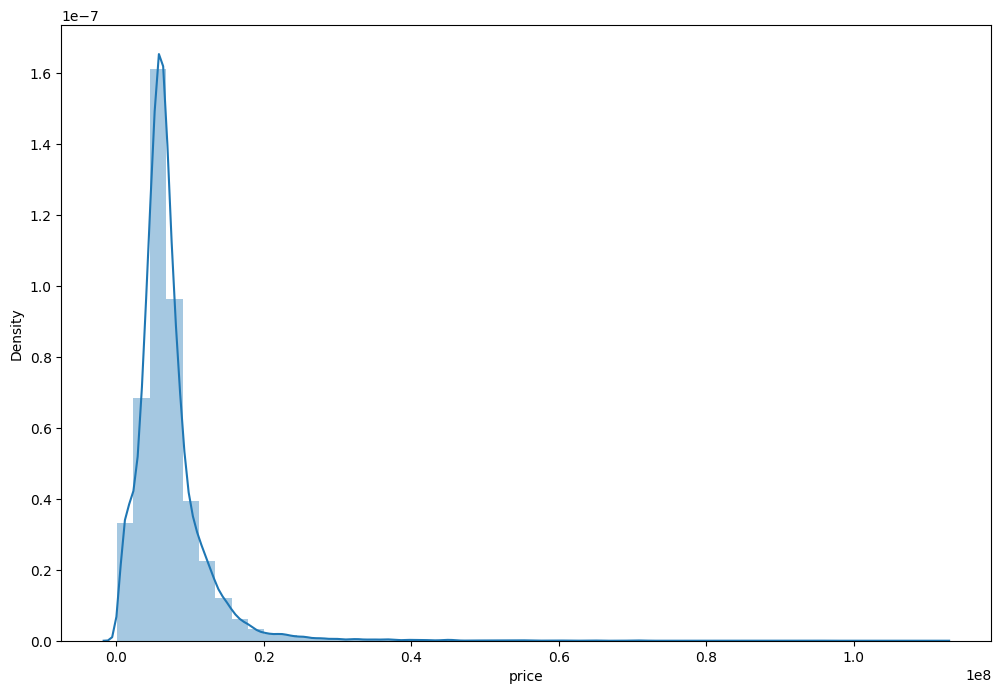

In [4]:
plt.figure(figsize=(12,8))
sns.distplot(df.price_doc.values, bins=50, kde=True)
plt.xlabel('price')
plt.show()

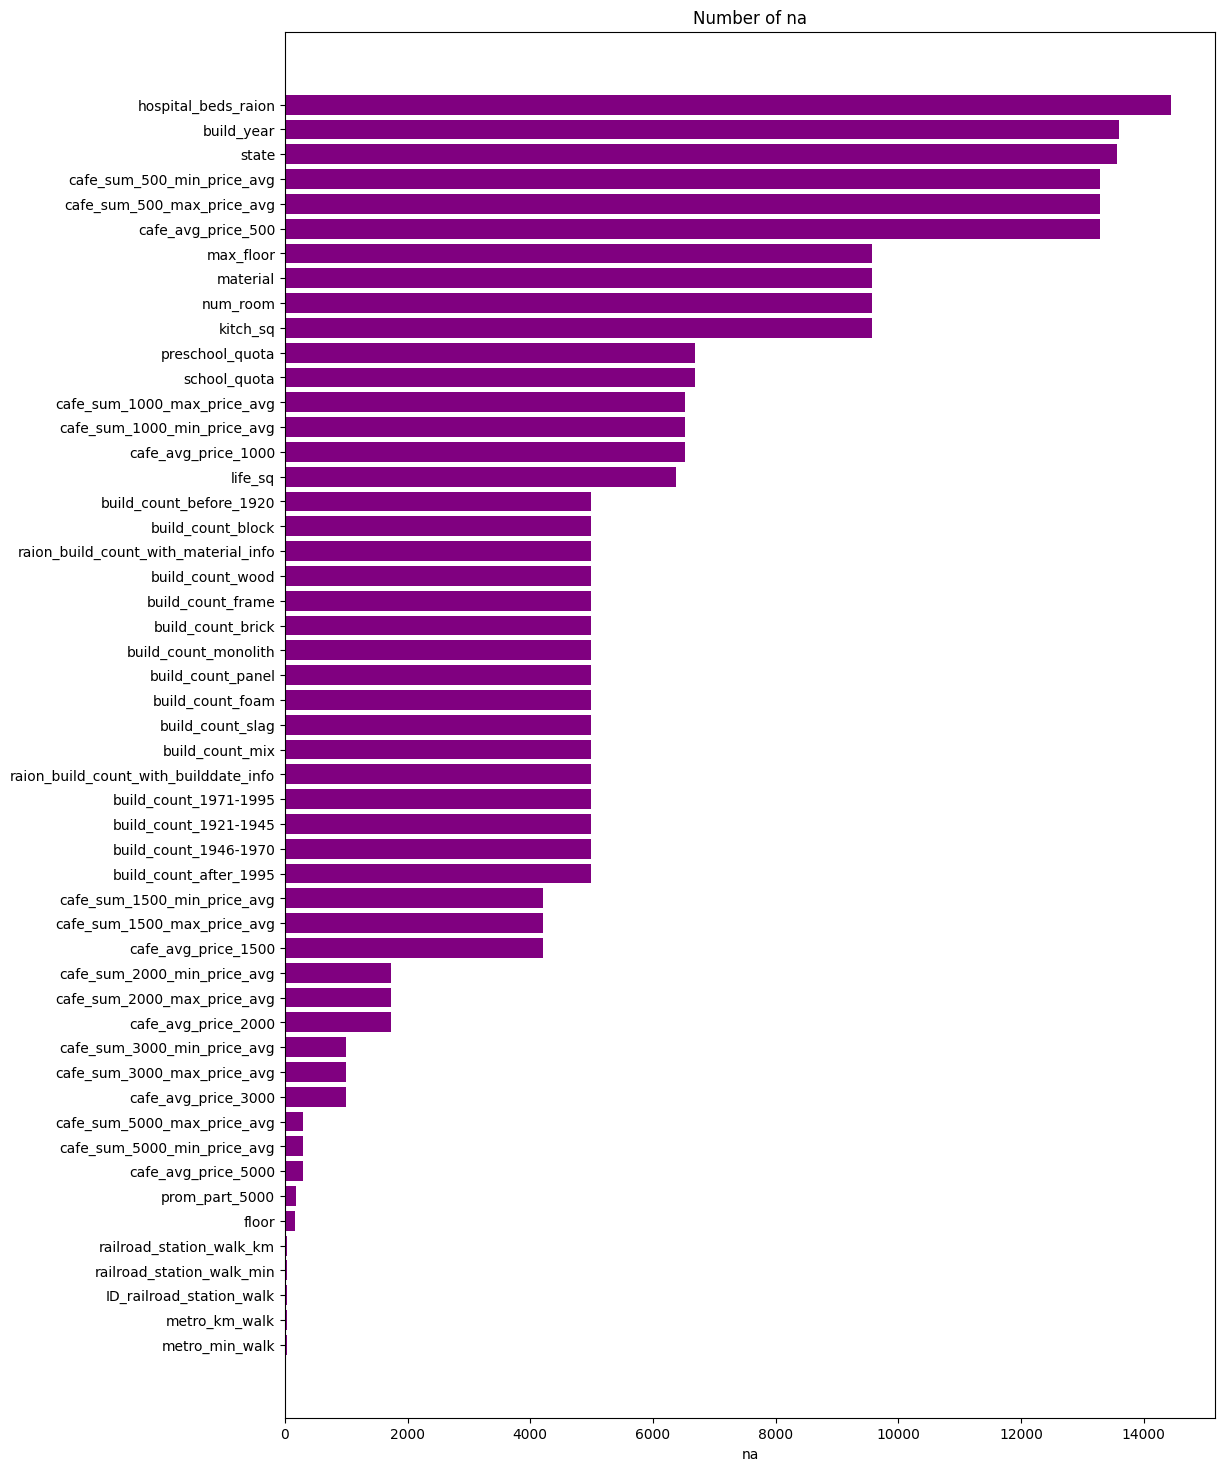

In [5]:
na_df = df.isnull().sum(axis=0).reset_index()
na_df.columns = ['column_name', 'na_count']
na_df = na_df.loc[na_df['na_count'] > 0, :]
na_df = na_df.sort_values(by='na_count')
ind = range(na_df.shape[0])

fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, na_df['na_count'], color="purple")
ax.set_yticks(ind)
ax.set_yticklabels(na_df.column_name.values, rotation='horizontal')
ax.set_xlabel("na")
ax.set_title("Number of na")
plt.show()

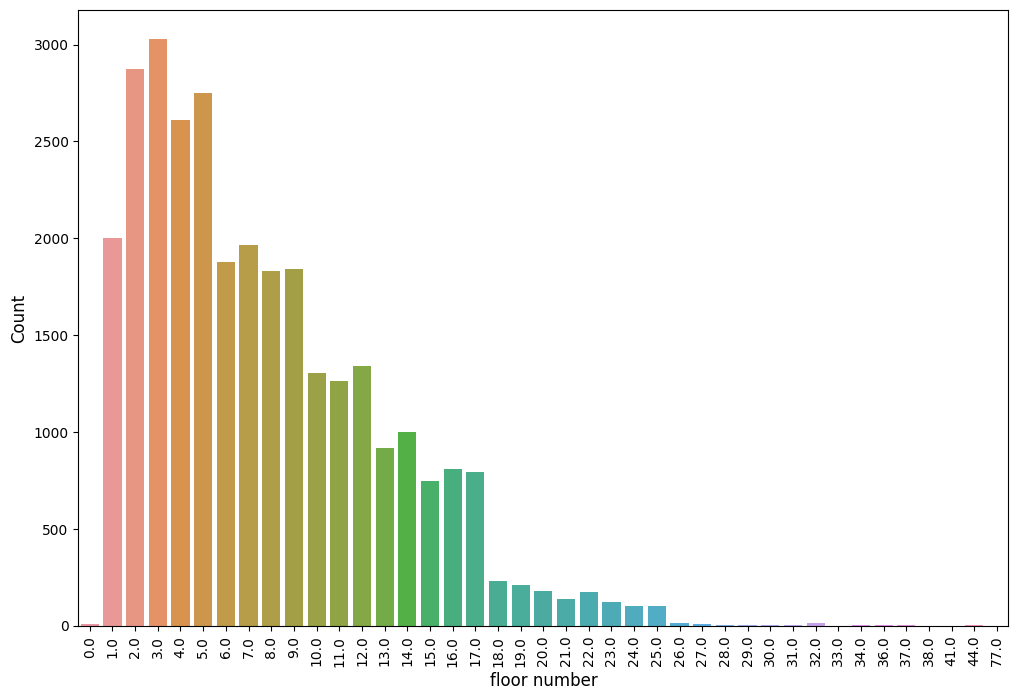

In [6]:
plt.figure(figsize=(12,8))
sns.countplot(x='floor', data=df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

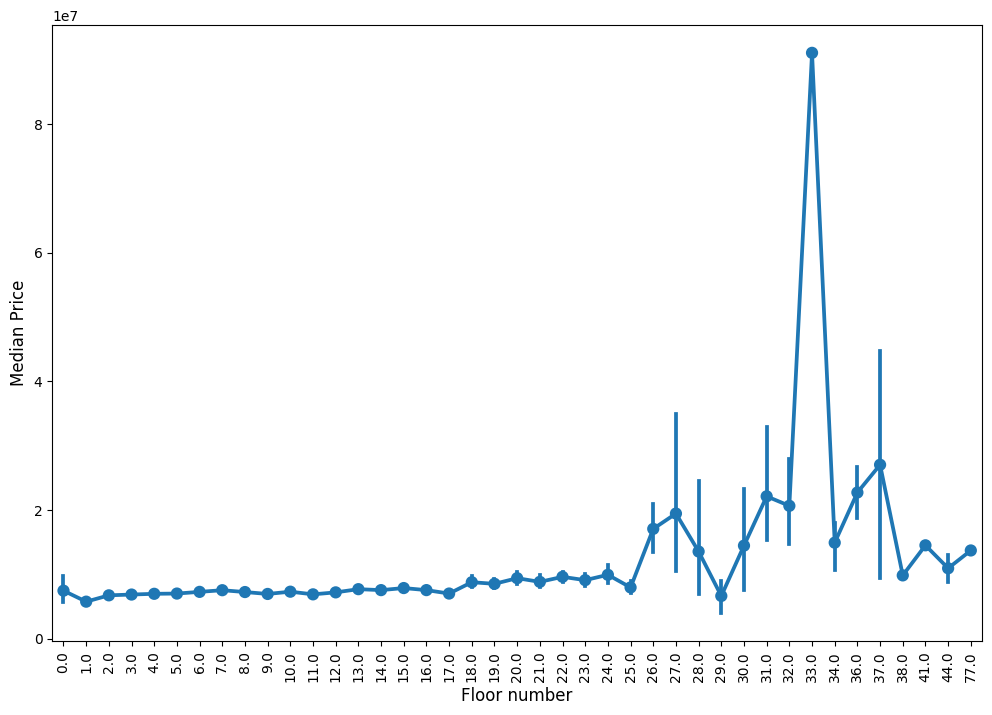

In [7]:
temp_df = df.groupby(['floor'])['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(x='floor', y='price_doc', data=df)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

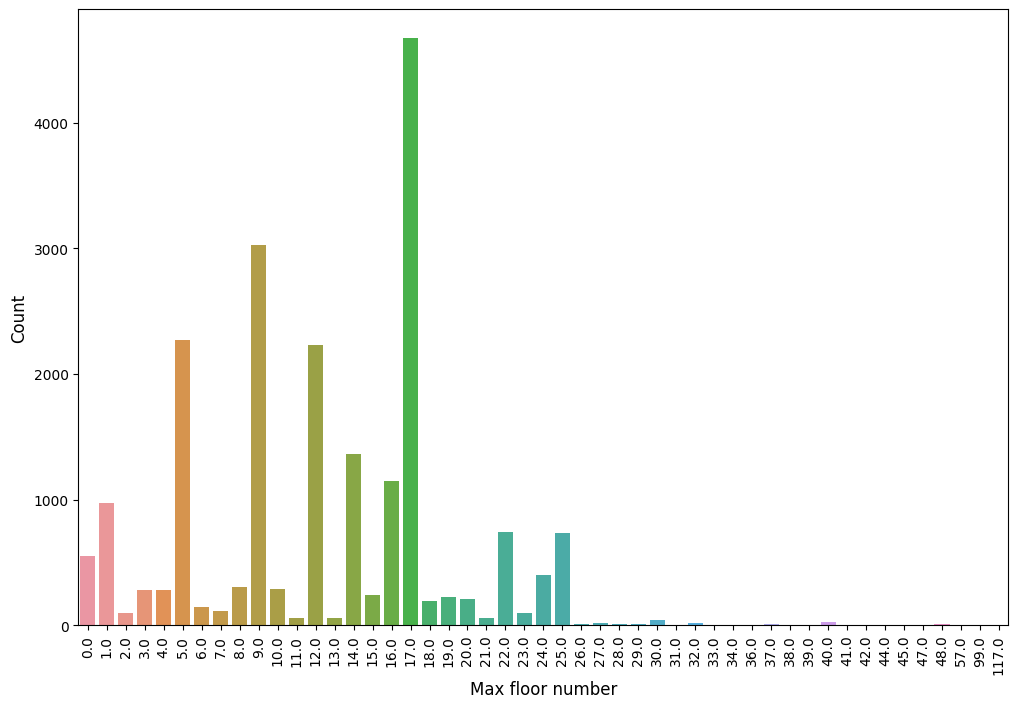

In [8]:
plt.figure(figsize=(12,8))
sns.countplot(x="max_floor", data=df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Max floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [9]:
# drop excessive cols about location
df.drop(['ID_metro', 'ID_railroad_station_walk','ID_railroad_station_avto','ID_big_road1','ID_big_road2','ID_railroad_terminal','ID_bus_terminal', 'id'],
        axis=1, inplace=True)

# Categorical cols
cat_cols = df.loc[:,df.dtypes==object].columns

for col in cat_cols:
    if col != 'timestamp': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        df[col] = lbl.transform(list(df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
            
y = df["price_doc"]
df.drop('price_doc', axis=1, inplace=True)

num_cols = df.loc[:,df.dtypes!=object].columns
# fill nulls with mean
for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())
    test_df[col] = test_df[col].fillna(test_df[col].mean())

# drop cols where corr > 0.65
threshold = 0.65
col_corr = set() 
corr_matrix = df.corr(numeric_only=True)
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
            name = corr_matrix.columns[i] 
            col_corr.add(name)
            if name in df.columns:
                del df[name]  
                del test_df[name]

df.drop('timestamp', axis=1, inplace=True)
test_df.drop('timestamp', axis=1, inplace=True)

#cols = df.columns
#test_df = pd.DataFrame(df, columns=cols)

[0]	train-rmsle:0.61742	test-rmsle:0.61249
[5]	train-rmsle:0.56995	test-rmsle:0.56671
[10]	train-rmsle:0.53946	test-rmsle:0.53880
[15]	train-rmsle:0.51853	test-rmsle:0.52045
[20]	train-rmsle:0.50314	test-rmsle:0.50693
[25]	train-rmsle:0.49090	test-rmsle:0.49675
[30]	train-rmsle:0.48286	test-rmsle:0.49061
[35]	train-rmsle:0.47698	test-rmsle:0.48642
[40]	train-rmsle:0.47168	test-rmsle:0.48259
[45]	train-rmsle:0.46682	test-rmsle:0.47976
[50]	train-rmsle:0.46374	test-rmsle:0.47810
[55]	train-rmsle:0.46055	test-rmsle:0.47639
[60]	train-rmsle:0.45840	test-rmsle:0.47553
[65]	train-rmsle:0.45632	test-rmsle:0.47471
[70]	train-rmsle:0.45429	test-rmsle:0.47372
[75]	train-rmsle:0.45247	test-rmsle:0.47311
[80]	train-rmsle:0.45059	test-rmsle:0.47250
[85]	train-rmsle:0.44925	test-rmsle:0.47217
[90]	train-rmsle:0.44744	test-rmsle:0.47175
[95]	train-rmsle:0.44607	test-rmsle:0.47126
[100]	train-rmsle:0.44489	test-rmsle:0.47083
[105]	train-rmsle:0.44364	test-rmsle:0.47057
[109]	train-rmsle:0.44278	test-r

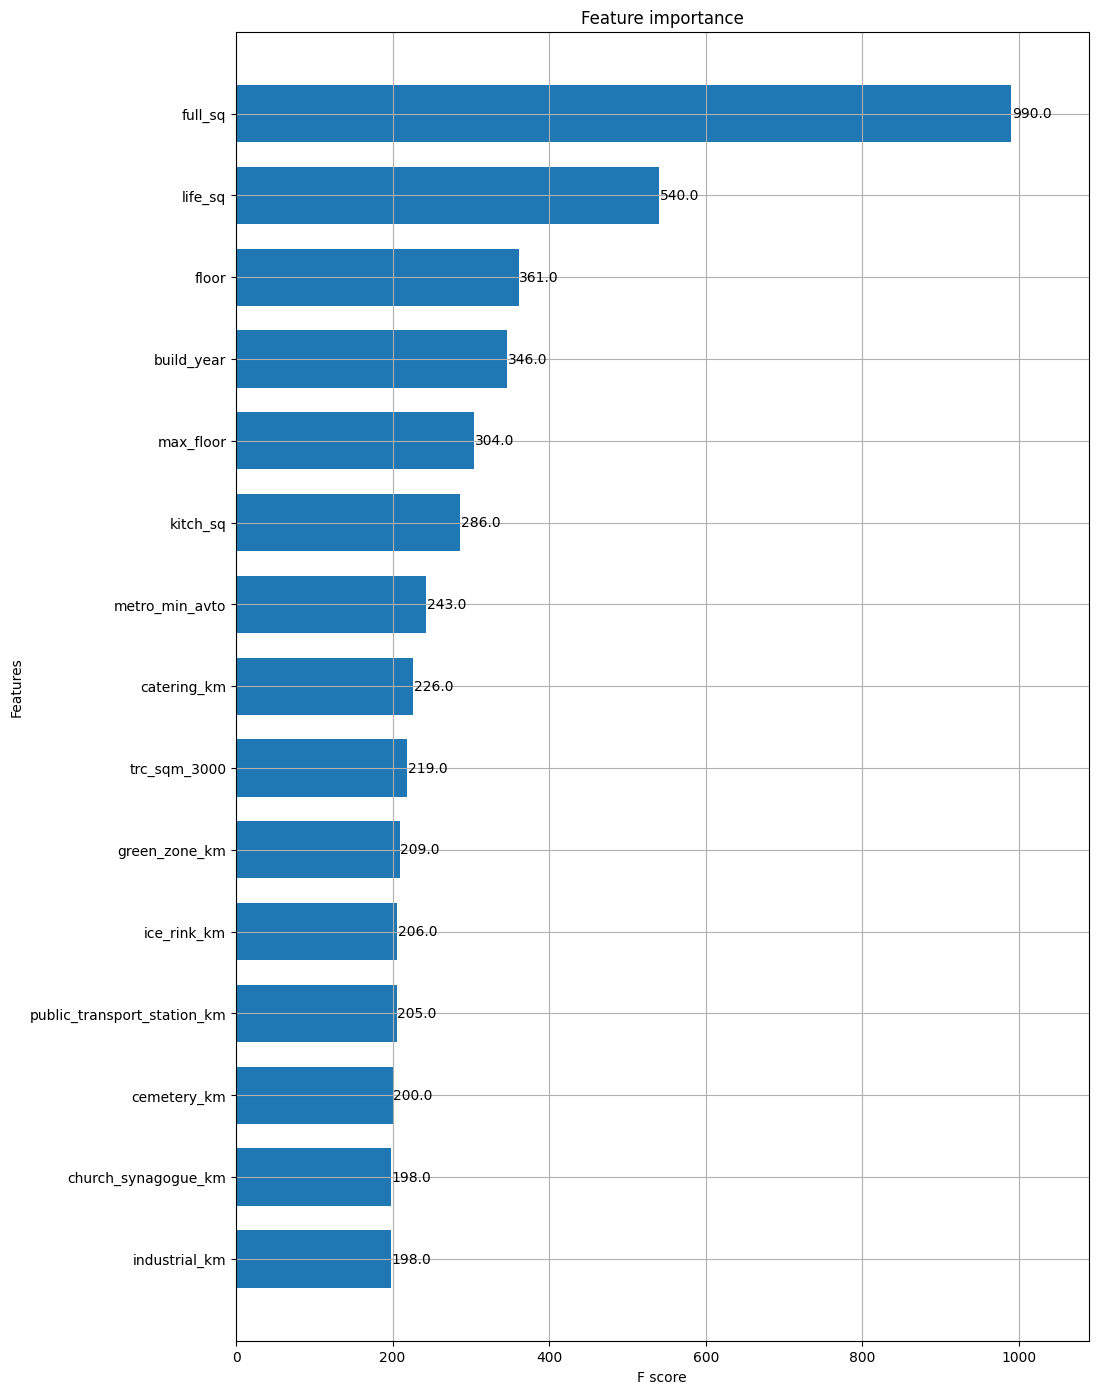

In [10]:
xgb_params = {'eta': 0.05,'max_depth': 7,'subsample': 0.7,'colsample_bytree': 0.7,
              'objective': 'reg:linear','eval_metric': 'rmsle','seed': 0}

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, random_state = 0)
xgtrain = xgb.DMatrix(X_train, y_train, label=X_train.columns)
xgtest = xgb.DMatrix(X_test, y_test, label=X_test.columns)
watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
num_rounds = 110 
model = xgb.train(xgb_params, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=5)

fig, ax = plt.subplots(figsize=(11,17))
xgb.plot_importance(model, max_num_features=15, height=0.7, ax=ax)
plt.show()

In [20]:
main_cols = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'kitch_sq', 'metro_min_avto']
streamlit_df = pd.DataFrame(df, columns=main_cols)
xgb_params = {'eta': 0.05,'max_depth': 7,'subsample': 0.7,'colsample_bytree': 0.7,
              'objective': 'reg:linear','eval_metric': 'rmsle','seed': 0}
model = XGBRegressor(eta = 0.05, max_depth = 7,subsample = 0.7, colsample_bytree = 0.7,
                     eval_metric = 'rmsle', seed = 0)
model.fit(X_train, y_train)

pickle.dump(model, open("rmsle.dat", "wb"))

In [22]:
print(model.predict(X_test)[0])

4697522.5
